## Data loading

In [85]:
import pandas as pd
import seaborn as sns
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import json

import sys
sys.path.append('..')
from helpers import *

%matplotlib inline

In [3]:
# First glimpse of all the available movies in the dataset

column_movies = ["film_id", "movie_id", "title", "release_date", "gross_revenue", "duration_min", "language", "country", "categories"]

movies_df = pd.read_csv('../Data/MovieSummaries/movie.metadata.tsv', sep='\t', header=None, names=column_movies)
movies_df.head()

,film_id,movie_id,title,release_date,gross_revenue,duration_min,language,country,categories
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [46]:
# Dataframe of all the characters in the movies

column_characters = ["film_id", "movie_id", "release_date", "character", "born_date", "gender", "height", "ethnicity", "actor_name", "actor_age_at_movie_release", "actor_map_ID","character_ID","actor_ID"]

character_df = pd.read_csv('../Data/MovieSummaries/character.metadata.tsv', sep='\t', header=None, names = column_characters)
character_df.shape

(450669, 13)

In [6]:
# List of different actors 
actors = character_df['actor_name'].unique()

# Number of actors per movie  
films = character_df.groupby('movie_id').actor_name.count()

# Number of characters per movie 
char = character_df.groupby('movie_id').character.count()

We may look at the frequency of different actors (nb of movies/year), look at the histogram of number of times each actor played (distrib), look at when the age started (distrib), ...

## 1. Frequency of presence in movies per year 

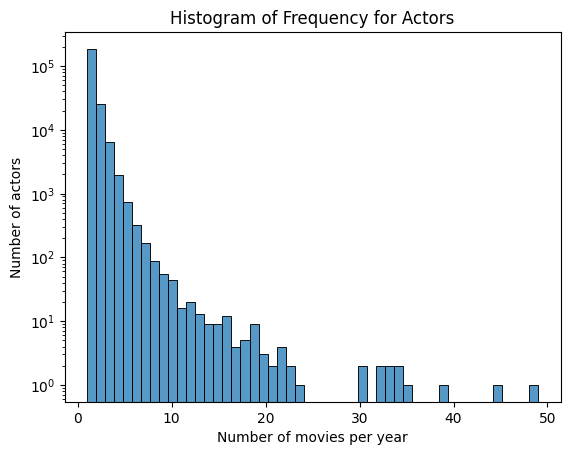

In [86]:
character_df['release_date'] = pd.to_datetime(character_df['release_date'], errors='coerce')

frequency_df = character_df.groupby(['actor_name', character_df['release_date'].dt.year]).size().reset_index(name='movie_count')

frequency_df = frequency_df.merge(character_df[['actor_name', 'gender']], on='actor_name', how='inner')
frequency_df = frequency_df.drop_duplicates(subset=['actor_name', 'release_date'])

count_char_df = pd.merge(character_df, movies_df[['movie_id', 'country']], on='movie_id', how='left')
count_char_df["country"] = (count_char_df["country"].apply(json.loads).apply(format_of_country_change))
count_char_df['region'] = count_char_df['country'].apply(get_region)

frequency_df = frequency_df.merge(count_char_df[['actor_name', 'region']], on='actor_name', how='inner')
frequency_df = frequency_df.drop_duplicates(subset=['actor_name', 'release_date'])


sns.histplot(frequency_df['movie_count'], bins= 50, log = True)
plt.ylabel("Number of actors")
plt.xlabel("Number of movies per year")
plt.title('Histogram of Frequency for Actors')
plt.show()

Possible limitations of the graph : outliers (we may look at who they are) and does a huge frquency over one year is better than a constant lower frequency ?  

In [87]:
frequency_max = frequency_df.sort_values(by='movie_count', ascending=False)
top5_frequency = frequency_max.head(5)
print(top5_frequency)

              actor_name  release_date  movie_count gender         region
2782038  Roscoe Arbuckle        1914.0           49      M  North America
2362269     Oliver Hardy        1916.0           45      M  North America
1129307     Harold Lloyd        1919.0           39      M  North America
2781880  Roscoe Arbuckle        1913.0           35      M  North America
481818   Charlie Chaplin        1914.0           34      M  North America


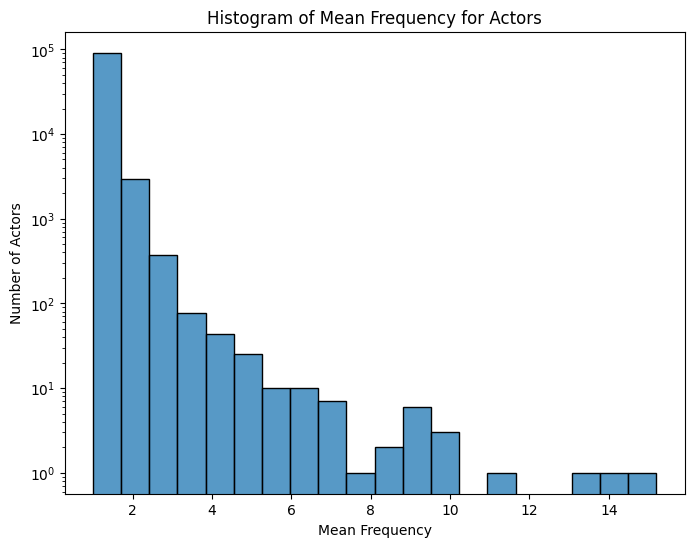

In [91]:
mean_frequency = frequency_df.groupby('actor_name')['movie_count'].mean().reset_index(name='mean_frequency')
mean_frequency = mean_frequency.merge(character_df[['actor_name', 'gender']], on='actor_name', how='inner')
mean_frequency = mean_frequency.merge(count_char_df[['actor_name', 'region']], on='actor_name', how='inner')

mean_frequency = mean_frequency.drop_duplicates(subset=['actor_name'])

plt.figure(figsize=(8, 6))
sns.histplot(mean_frequency['mean_frequency'], bins=20,log = True, kde=False)
plt.xlabel('Mean Frequency')
plt.ylabel('Number of Actors')
plt.title('Histogram of Mean Frequency for Actors')
plt.show()

In [92]:
top5_actors_mf = mean_frequency.nlargest(5, 'mean_frequency')
print(top5_actors_mf)

               actor_name  mean_frequency gender         region
1318450  Charlotte Burton            15.2      F  North America
4985633     Louise Lester            14.0      F  North America
3307334        Jack Davis            13.5    NaN  North America
9607198       Vivian Rich            11.2      F  North America
1185136    Caroline Cooke            10.0      F  North America


When we search for all these actors, we can see that they are all from the beginning of the movie industry (1910s, early 1920s) when the movies were quite short and silent, so the artistic approach was way more simplified as today. In fact, Roscoe Arbuckle worked as the same time as an actor, a screenwriter and a producer. 

By highlighting that, we could assess that taking into account the period at which the movies were produced is critical. 

So, we tried to filter by period : 

In [93]:
average_movie_count_per_year = frequency_df.groupby('release_date')['movie_count'].agg(['mean', 'std']).reset_index()
average_movie_count_per_year.columns = ['release_date', 'average_movies', 'std_dev']
average_movie_count_per_year.head(13)

,release_date,average_movies,std_dev
0,1894.0,1.000,NaN
1,1895.0,1.000,NaN
2,1896.0,1.000,0.000000
3,1897.0,1.000,NaN
4,1900.0,1.000,0.000000
5,1901.0,1.000,NaN
6,1902.0,1.000,0.000000
7,1903.0,1.000,0.000000
8,1904.0,1.000,NaN
9,1905.0,1.000,0.000000


We can filter all the years before 1908 which seems not very insightful, and then plot the average frequency per year with the standard deviation : 

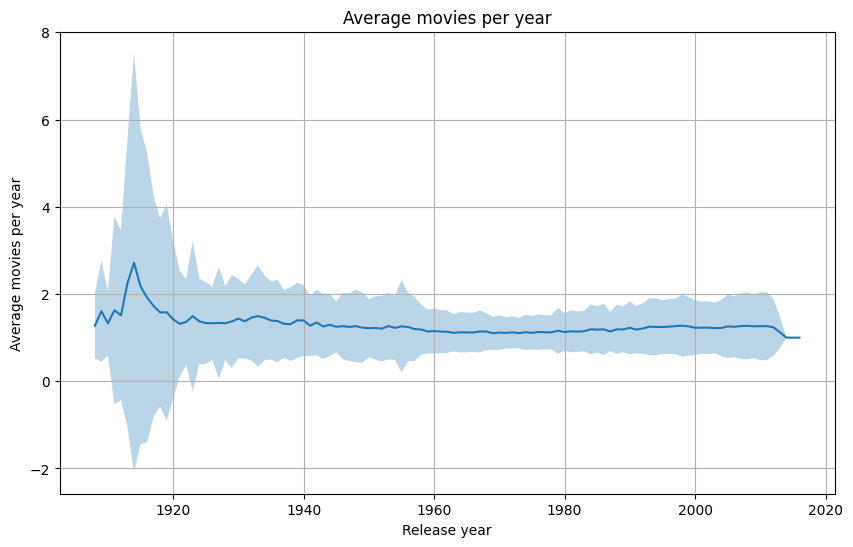

In [100]:
average_movie_count_per_year = average_movie_count_per_year[average_movie_count_per_year['release_date'] >= 1908]

plt.figure(figsize=(10, 6))
sns.lineplot(data=average_movie_count_per_year, x='release_date', y='average_movies')
plt.fill_between(average_movie_count_per_year['release_date'], 
                 average_movie_count_per_year['average_movies'] - average_movie_count_per_year['std_dev'],
                 average_movie_count_per_year['average_movies'] + average_movie_count_per_year['std_dev'],
                 alpha=0.3)
plt.xlabel('Release year')
plt.ylabel('Average movies per year')
plt.title('Average movies per year')
plt.grid(True)
plt.show()

We could also focus on gender through time :

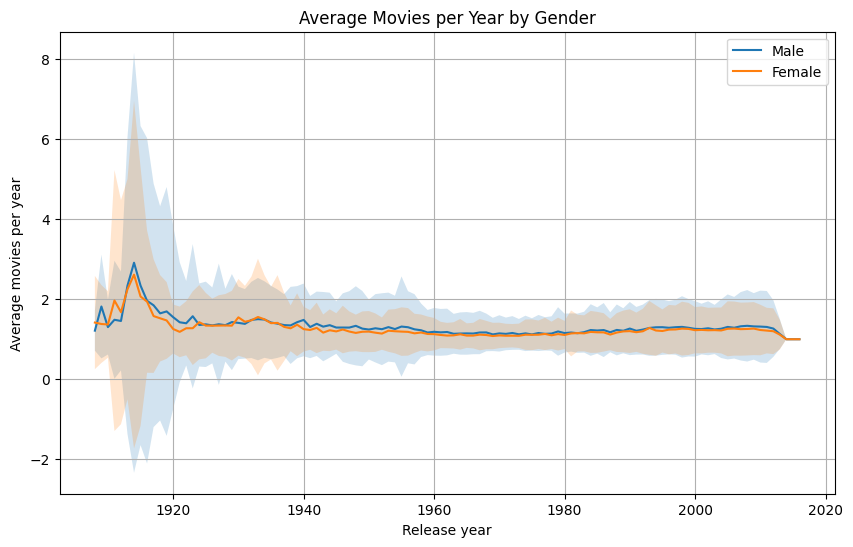

In [95]:
male_data = frequency_df[frequency_df['gender'] == 'M']
female_data = frequency_df[frequency_df['gender'] == 'F']

average_movie_count_male = male_data.groupby('release_date')['movie_count'].agg(['mean', 'std']).reset_index()
average_movie_count_male = average_movie_count_male[average_movie_count_male['release_date'] >= 1908]

average_movie_count_female = female_data.groupby('release_date')['movie_count'].agg(['mean', 'std']).reset_index()
average_movie_count_female = average_movie_count_female[average_movie_count_female['release_date'] >= 1908]

plt.figure(figsize=(10, 6))
sns.lineplot(data=average_movie_count_male, x='release_date', y='mean', label='Male')
plt.fill_between(average_movie_count_male['release_date'], 
                 average_movie_count_male['mean'] - average_movie_count_male['std'],
                 average_movie_count_male['mean'] + average_movie_count_male['std'],
                 alpha=0.2)

sns.lineplot(data=average_movie_count_female, x='release_date', y='mean', label='Female')
plt.fill_between(average_movie_count_female['release_date'], 
                 average_movie_count_female['mean'] - average_movie_count_female['std'],
                 average_movie_count_female['mean'] + average_movie_count_female['std'],
                 alpha=0.2)

plt.xlabel('Release year')
plt.ylabel('Average movies per year')
plt.title('Average movies per year by gender')
plt.legend()
plt.grid(True)
plt.show()

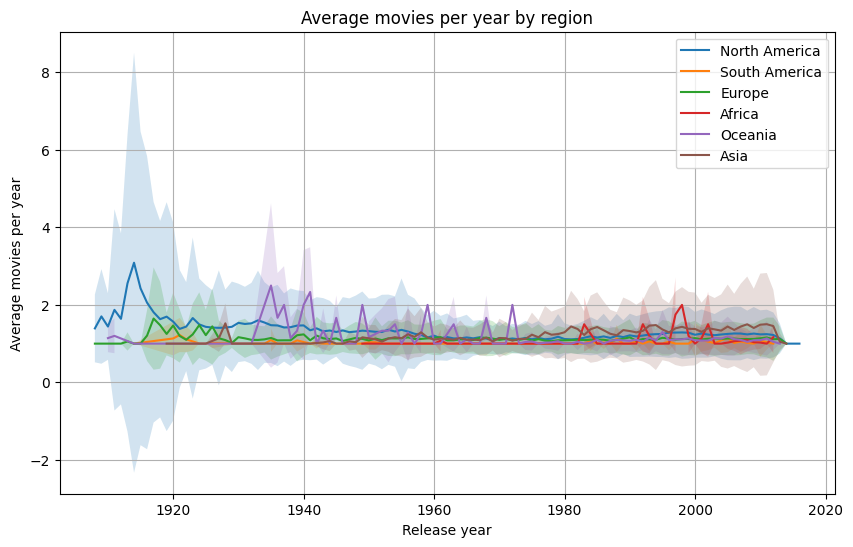

In [99]:
NA_data = frequency_df[frequency_df['region'] == 'North America']
SA_data = frequency_df[frequency_df['region'] == 'South America']
EU_data = frequency_df[frequency_df['region'] == 'Europe']
AF_data = frequency_df[frequency_df['region'] == 'Africa']
OC_data = frequency_df[frequency_df['region'] == 'Oceania']
AS_data = frequency_df[frequency_df['region'] == 'Asia']

average_movie_count_NA = NA_data.groupby('release_date')['movie_count'].agg(['mean', 'std']).reset_index()
average_movie_count_NA = average_movie_count_NA[average_movie_count_NA['release_date'] >= 1908]

average_movie_count_SA = SA_data.groupby('release_date')['movie_count'].agg(['mean', 'std']).reset_index()
average_movie_count_SA = average_movie_count_SA[average_movie_count_SA['release_date'] >= 1908]

average_movie_count_EU = EU_data.groupby('release_date')['movie_count'].agg(['mean', 'std']).reset_index()
average_movie_count_EU = average_movie_count_EU[average_movie_count_EU['release_date'] >= 1908]

average_movie_count_AF = AF_data.groupby('release_date')['movie_count'].agg(['mean', 'std']).reset_index()
average_movie_count_AF = average_movie_count_AF[average_movie_count_AF['release_date'] >= 1908]

average_movie_count_OC = OC_data.groupby('release_date')['movie_count'].agg(['mean', 'std']).reset_index()
average_movie_count_OC = average_movie_count_OC[average_movie_count_OC['release_date'] >= 1908]

average_movie_count_AS = AS_data.groupby('release_date')['movie_count'].agg(['mean', 'std']).reset_index()
average_movie_count_AS = average_movie_count_AS[average_movie_count_AS['release_date'] >= 1908]


plt.figure(figsize=(10, 6))
sns.lineplot(data=average_movie_count_NA, x='release_date', y='mean', label='North America')
plt.fill_between(average_movie_count_NA['release_date'], 
                 average_movie_count_NA['mean'] - average_movie_count_NA['std'],
                 average_movie_count_NA['mean'] + average_movie_count_NA['std'],
                 alpha=0.2)

sns.lineplot(data=average_movie_count_SA, x='release_date', y='mean', label='South America')
plt.fill_between(average_movie_count_SA['release_date'], 
                 average_movie_count_SA['mean'] - average_movie_count_SA['std'],
                 average_movie_count_SA['mean'] + average_movie_count_SA['std'],
                 alpha=0.2)

sns.lineplot(data=average_movie_count_EU, x='release_date', y='mean', label='Europe')
plt.fill_between(average_movie_count_EU['release_date'], 
                 average_movie_count_EU['mean'] - average_movie_count_EU['std'],
                 average_movie_count_EU['mean'] + average_movie_count_EU['std'],
                 alpha=0.2)

sns.lineplot(data=average_movie_count_AF, x='release_date', y='mean', label='Africa')
plt.fill_between(average_movie_count_AF['release_date'], 
                 average_movie_count_AF['mean'] - average_movie_count_AF['std'],
                 average_movie_count_AF['mean'] + average_movie_count_AF['std'],
                 alpha=0.2)

sns.lineplot(data=average_movie_count_OC, x='release_date', y='mean', label='Oceania')
plt.fill_between(average_movie_count_OC['release_date'], 
                 average_movie_count_OC['mean'] - average_movie_count_OC['std'],
                 average_movie_count_OC['mean'] + average_movie_count_OC['std'],
                 alpha=0.2)

sns.lineplot(data=average_movie_count_AS, x='release_date', y='mean', label='Asia')
plt.fill_between(average_movie_count_AS['release_date'], 
                 average_movie_count_AS['mean'] - average_movie_count_AS['std'],
                 average_movie_count_AS['mean'] + average_movie_count_AS['std'],
                 alpha=0.2)

plt.xlabel('Release year')
plt.ylabel('Average movies per year')
plt.title('Average movies per year by region')
plt.legend()
plt.grid(True)
plt.show()

## 2. Career span of actors

Mean career span for male actors: 13.08 years (+/-  11.21) 
Mean career span for female actors: 11.38 years (+/- 10.74) 


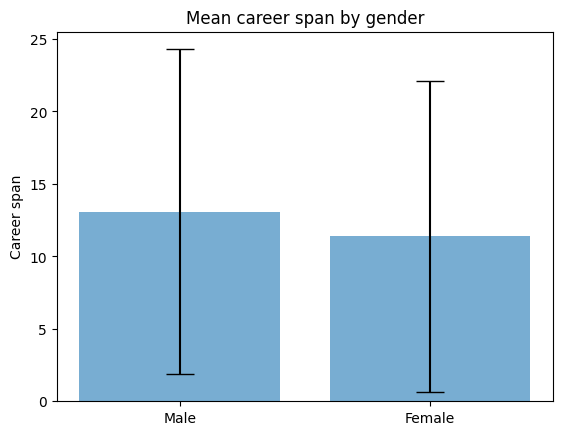

In [17]:
character_df['release_date'] = pd.to_datetime(character_df['release_date'], errors='coerce')

actor_span = character_df.groupby('actor_name')['release_date'].agg(['min', 'max']).reset_index()
actor_span['career_span'] = (actor_span['max'] - actor_span['min']).dt.days / 365

# Avoid anomalies due to missing values (NaT)
span_thresh = 50 
actor_span = actor_span[(actor_span['career_span'] != 0) & (actor_span['career_span'] < span_thresh)]
actor_career_span = actor_span.merge(character_df[['actor_name', 'gender']], on='actor_name', how='inner')
actor_career_span = actor_career_span.drop_duplicates(subset=['actor_name', 'career_span', 'gender'])

male_actors = actor_career_span[actor_career_span['gender'] == 'M']
female_actors = actor_career_span[actor_career_span['gender'] == 'F']

# Calculate mean career span for male and female actors and std and plot with confidence intervals
mean_career_span_male = male_actors['career_span'].mean()
std_career_span_male = male_actors['career_span'].std()
mean_career_span_female = female_actors['career_span'].mean()
std_career_span_female = female_actors['career_span'].std()

print(f"Mean career span for male actors: {mean_career_span_male:.2f} years (+/-  {std_career_span_male:.2f}) ")
print(f"Mean career span for female actors: {mean_career_span_female:.2f} years (+/- {std_career_span_female:.2f}) ")

labels = ['Male', 'Female']
x_pos = range(len(labels))
plt.bar(x_pos, [mean_career_span_male, mean_career_span_female], yerr=[std_career_span_male, std_career_span_female], align='center', alpha=0.6, ecolor='black', capsize=10)
plt.xticks(x_pos, labels)
plt.ylabel('Career span')
plt.title('Mean career span by gender')

plt.show()

This is a relatively high variance, so we can not assess anything about the career span of male or female yet. Let's try to do a t-test : 

In [18]:
from scipy.stats import ttest_ind

t_statistic, p_value = ttest_ind(male_actors['career_span'], female_actors['career_span'])

print(f"t-statistic: {t_statistic:.2f}, p-value: {p_value:.4f}")

t-statistic: 13.15, p-value: 0.0000


We can assess that there is strong evidence about the difference between male and female actors. 

## 3. Number of movies per actor

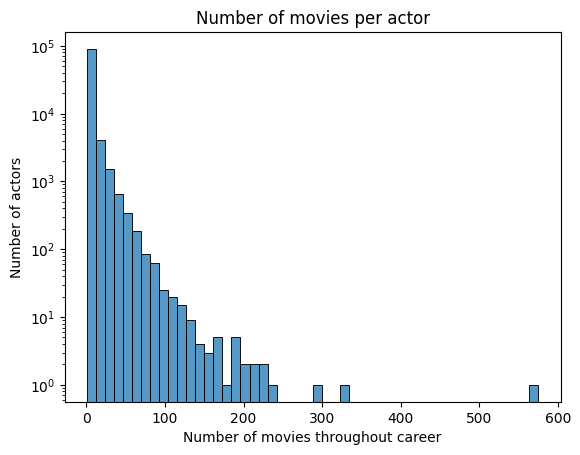

In [19]:
actor_nb_movie = character_df.groupby(['actor_name', 'gender', 'movie_id']).size().reset_index(name='appearance_count')
actor_nb_movie = actor_nb_movie.groupby(['actor_name', 'gender']).size().reset_index(name='total_movie_count')

sns.histplot(actor_nb_movie, x='total_movie_count', bins=50, log=True)
plt.ylabel("Number of actors")
plt.xlabel("Number of movies throughout career")
plt.title("Number of movies per actor")
plt.show()

In [20]:
sorted_actors = actor_nb_movie.sort_values(by='total_movie_count', ascending=False) 
top_5_actors_corrected = sorted_actors.head(5)
print(top_5_actors_corrected)

               actor_name gender  total_movie_count
62041           Mel Blanc      M                575
64910  Mithun Chakraborty      M                328
69057        Oliver Hardy      M                299
65110            Mohanlal      M                234
57406           Mammootty      M                225


The top 5 is mainly composed of mens, let's try to compare with women. In fact, we may have to consider productions locally and by period too, because the leaderboard is exclusively from America in the early ages of cinema and from India nowadays for example.

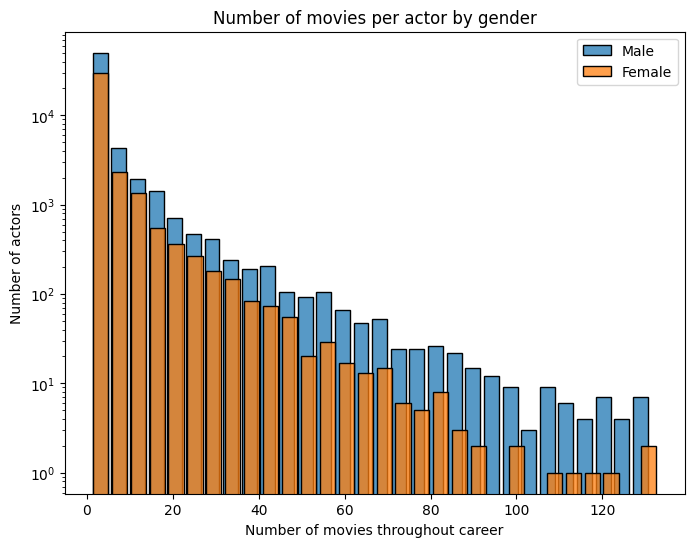

In [21]:
male_data = actor_nb_movie[actor_nb_movie['gender'] == 'M']
female_data = actor_nb_movie[actor_nb_movie['gender'] == 'F']

# The max number of movies for women are 133 so we filter values above to compare
male_filtered = male_data[male_data['total_movie_count'] <= 133]
female_filtered = female_data[female_data['total_movie_count'] <= 133]

# Plotting separate histograms for men and women with filtered data
plt.figure(figsize=(8, 6))
sns.histplot(male_filtered['total_movie_count'], bins=30, label='Male', log=True, multiple="dodge", shrink=.8)
sns.histplot(female_filtered['total_movie_count'], bins=30, label='Female', log=True, multiple="dodge", shrink=.8)

plt.ylabel("Number of actors")
plt.xlabel("Number of movies throughout career")
plt.title("Number of movies per actor by gender")
plt.legend()
plt.show()

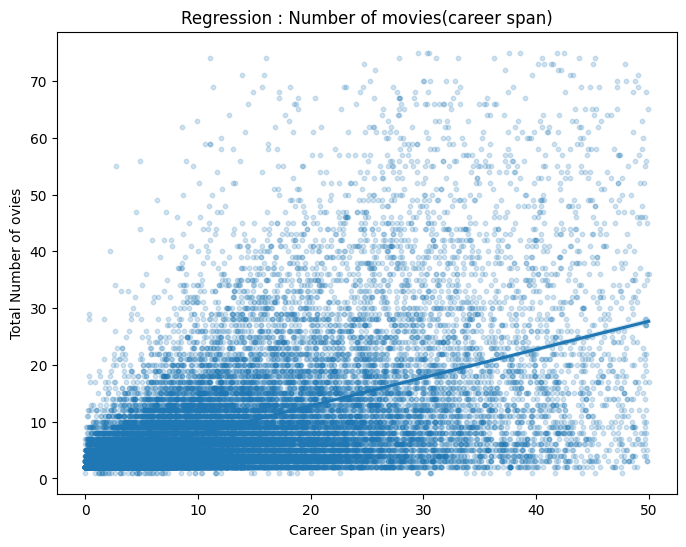

In [22]:
merged_data = pd.merge(actor_span, actor_nb_movie, on='actor_name', how='inner')

# Remove outliers for better visualization
thresh = 75
merged_data = merged_data[merged_data['total_movie_count'] <=  thresh]

# Perform a regression
plt.figure(figsize=(8, 6))
sns.regplot(x='career_span', y='total_movie_count', data=merged_data, scatter_kws={"s": 10, "alpha": 0.2})
plt.xlabel("Career Span (in years)")
plt.ylabel("Total Number of ovies")
plt.title("Regression : Number of movies(career span)")
plt.show()

## 4. Combining all three factors

IndexError: index 3 is out of bounds for axis 0 with size 3

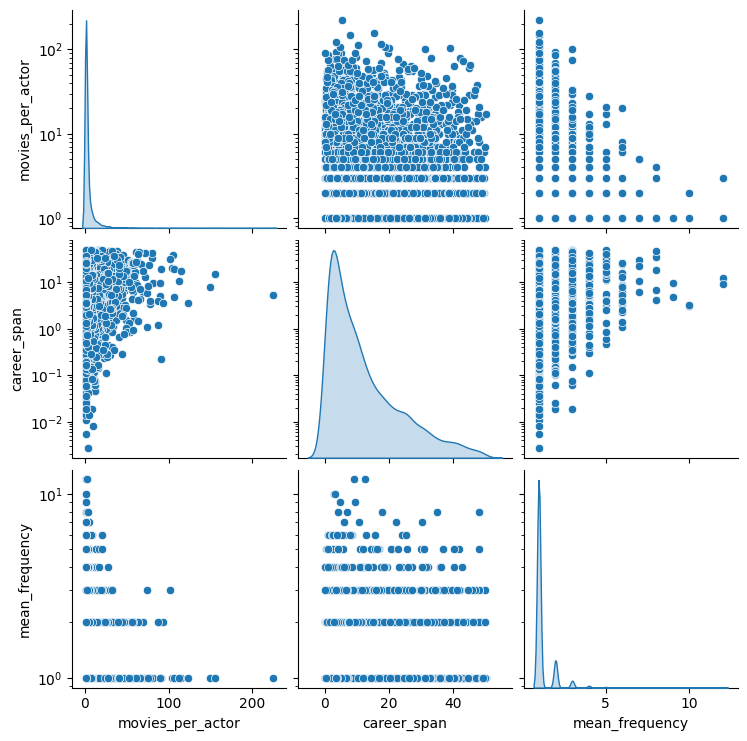

In [27]:
actor_metrics = pd.DataFrame({
    'actor_name': actor_nb_movie['actor_name'],
    'movies_per_actor': actor_nb_movie['total_movie_count'],
    'career_span': actor_career_span['career_span'],  
    'mean_frequency': frequency_df['movie_count'],
})

actor_metrics = actor_metrics.dropna()  

g = sns.pairplot(actor_metrics, diag_kind='kde')

# Apply log scale to all diagonal plots for better visualization
for i in range(g.axes.shape[0]):
    for j in range(g.axes.shape[1]):
        ax = g.axes[i, j]
        if i == j:
            ax.set_yscale('log')

plt.suptitle('Scatter plot of metrics')
plt.show()